In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pandas_datareader
#import pandas_datareader.moex as moex
import moex

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [20, 6]
#plt.rcParams['figure.dpi'] = 200 # 200

In [2]:
def remove_suffix(series):
    rep_pattern = '|'.join(('ао', 'ап', '-п', '-гдр', '-адр', ' др'))
    a = series.str.replace(rep_pattern, '')
    return a.str.rstrip('3').str.rstrip('-').str.rstrip(' ')

In [3]:
# Грузим стоки с Мос.Биржи
imoex = moex.get_stocks_in_indices('IMOEX')

# Грузим последние цены
a = moex.get_stocks()[['LOTSIZE','WAPRICE']]

imoex['price'] = a['LOTSIZE']*a['WAPRICE']

# Чистим наименования от суффиксов
imoex['shortnames'] = remove_suffix(imoex['shortnames'])

# Группируем по компаниям
imoex = imoex.groupby('shortnames').agg({'weight': 'sum', 'price': 'mean'}).sort_values('weight', ascending=False)
# Приводим веса к числу с плавующей точнкой
imoex['weight'] = imoex['weight']/100

https://iss.moex.com/iss/statistics/engines/stock/markets/index/analytics/IMOEX.csv?iss.only=analytics&limit=100&start=0


# Расчитываем свой индекс
$$w_i=\frac {\frac{1}{n} + W_i^{[IMOEX]}}{1+\sum_{k=1}^n{W_k^{[IMOEX]}}}$$

In [4]:
imoex['myIMOEX'] = (1/imoex['weight'].count()+ imoex['weight'])/(1+imoex['weight'].sum())

## Загрузка портфеля

In [5]:
b = {
'АЛРОСА ао':25783.9,
'Аэрофлот':18662.8,
'ВТБ ао':20198.7,
'ГАЗПРОМ ао':20102.5,
'ГМКНорНик':21578,
'ДетскийМир':24228.4,
'ИнтерРАОао':20604,
'ЛСР ао':22770,
'ЛУКОЙЛ':20308,
'Магнит ао':24985,
'МКБ ао':19730.7,
'ММК':25326,
'МосБиржа':21385,
'МТС-ао':19209,
'НЛМК ао':25113.4,
'Новатэк ао':21765.6,
'ПИК ао':29840,
'Полюс':14502,
'Роснефть':26979,
'Россети ао':16958.5,
'Ростел -ао':19015.5,
'РУСАЛ ао':24644.4,
'РусГидро':20298.2,
'Сбербанк':23873.5,
'СевСт-ао':23704.8,
'Система ао':30763,
'Сургнфгз':22606.5,
'Татнфт 3ао':20759.1,
'ФосАгро ао':21098,
'ФСК ЕЭС ао':20152,
'Юнипро ао':19425,
'FIVE-гдр':21940,
'iQIWI':4450,
'MAIL-гдр':15575,
'Polymetal':14312.7,
'TCS-гдр':30420,
'Yandex clA':31804.8,
'КМЗ':621.00,
'Лента др':13158.0,   
}

In [6]:
c = pd.DataFrame(b.items(), columns=['shortnames','portfolio'])
c['shortnames'] = remove_suffix(c['shortnames'])
# Группируем по компаниям
c = c.groupby('shortnames').sum().sort_values('portfolio', ascending=False)
portfolio_value = c['portfolio'].sum()
c['portfolio']=c['portfolio']/c['portfolio'].sum()
imoex = pd.concat([imoex,c], axis=1)
imoex.fillna(0, inplace=True)

## Сравнение

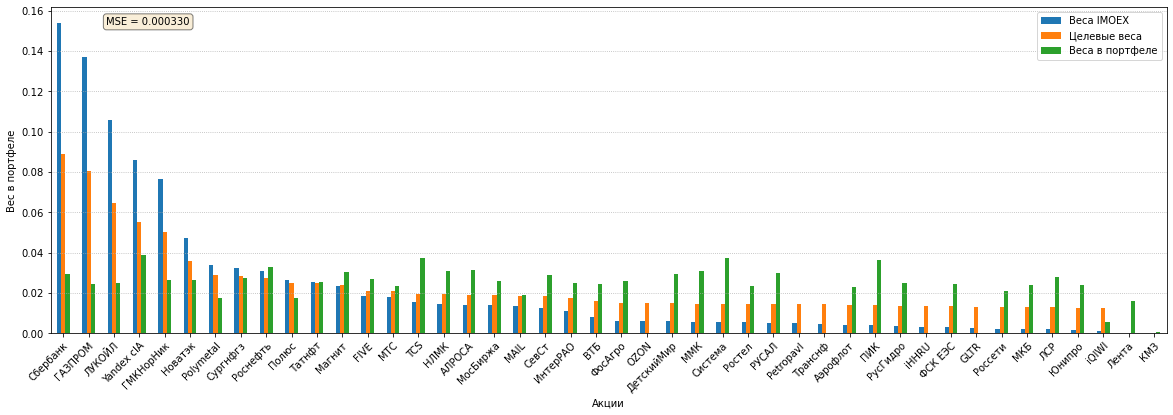

In [7]:
m = imoex['myIMOEX']-imoex['portfolio']
mse = (m**2).mean()

ax = imoex[['weight', 'myIMOEX', 'portfolio']].plot.bar()
ax.grid(axis='y', linestyle=':')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.97, f"MSE = {mse:0.6f}", transform=ax.transAxes, verticalalignment='top', bbox=props)
ax.set_ylabel('Вес в портфеле')
ax.set_xlabel('Акции')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right" , rotation=45, rotation_mode="anchor");
plt.legend(labels=['Веса IMOEX', 'Целевые веса', 'Веса в портфеле']);

## Приоритет покупки новых акций

In [8]:
imoex['priority'] = m/imoex['myIMOEX']
imoex['lots'] = (portfolio_value * imoex['myIMOEX'] / imoex['price'] ).round(0)

In [9]:
imoex.sort_values(by= ['priority','price'], ascending=[False, True])[['myIMOEX', 'priority','price', 'lots']]

,myIMOEX,priority,price,lots
iHHRU,0.013455,1.000000,2138.00,5.0
Petropavl,0.014405,1.000000,3199.50,4.0
OZON,0.014955,1.000000,3210.50,4.0
GLTR,0.013255,1.000000,4435.00,2.0
Транснф,0.014305,1.000000,140300.00,0.0
ГАЗПРОМ,0.080355,0.694410,2111.30,31.0
Сбербанк,0.089005,0.672355,2580.45,28.0
ЛУКОЙЛ,0.064855,0.617505,5131.50,10.0
iQIWI,0.012555,0.567036,765.00,13.0
ГМКНорНик,0.050155,0.474467,23308.00,2.0
